In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [10]:
class L63Dataset(object):
    h = 1e-3
    M = 40
    Tf = 20
    NT = int(Tf/h)
    T = np.linspace(0, 20, int(NT/M))[1:].reshape(-1, 1)

    def __init__(self, data_path):

        # Data path
        mesh_path = os.path.join(data_path, 'mesh.npy')
        priorpdfn_path = os.path.join(data_path, 'prior.npy')

        # Read numpy matrices
        mesh = np.load(mesh_path)
        priorpdfn = np.load(priorpdfn_path)

        # Convert numpy to tensor
        self.mesh = torch.from_numpy(mesh).reshape((-1, 3))
        self.Nx = self.mesh.shape[0]
        
        self.ts = torch.from_numpy(self.T)
        self.Nt = self.ts.shape[0]
        
        self.pdf = torch.unsqueeze(torch.from_numpy(priorpdfn), dim=-1)
        self.pdf = self.pdf.reshape((self.Nt, self.Nx, 1))


    def sample_points(self, n, thresh=1e-4, ratio=0.5):

        assert (n<=self.Nx*self.Nt), f'Too many points to sample: {n}>{self.Nx*self.Nt}'

        itpos, ixpos, _ = torch.where(self.pdf>=thresh)
        itzero, ixzero, _ = torch.where(self.pdf<thresh)

        npos = int(np.ceil(ratio*n))
        nzero = int(np.floor((1-ratio)*n))

        ix = torch.concat([ixpos[torch.randint(len(ixpos), size=(npos,))],
                           ixzero[torch.randint(len(ixzero), size=(nzero,))]])
        
        it = torch.concat([itpos[torch.randint(len(itpos), size=(npos,))],
                           itzero[torch.randint(len(itzero), size=(nzero,))]])

        xsample = self.mesh[ix]
        tsample = self.ts[it]
        ysample = self.pdf[it, ix]

        return (xsample, tsample), ysample


In [11]:
data_path = '/project/data/l63'
l63ds = L63Dataset(data_path=data_path)

In [17]:
n = 12800
(xsample, tsample), ysample = l63ds.sample_points(n, thresh=10.0, ratio=0.6)
xsample.shape, tsample.shape, ysample.shape

(torch.Size([12800, 3]), torch.Size([12800, 1]), torch.Size([12800, 1]))

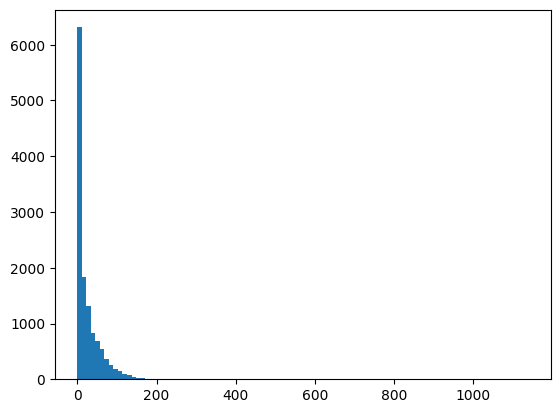

In [18]:
_ = plt.hist(ysample.flatten(), bins=100)
# plt.xscale('log')
# plt.yscale('log')